In [1]:
from Dataload import dataload

from module import resnet,transformer,video_model,invres

import torch
import torch.nn as nn
from torchsummary import summary
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt
from torchvision import  utils
#Batchfy


#Counts number of correct label
def num_correct(prediction,labels):
    correct=0
    for i,(pred_label,label) in enumerate(zip(prediction,labels)):
        if (pred_label.item()==label.item()):
            correct +=1
    return correct


train_data=dataload.Video_Frame_Data('Dataset/Train_labels.txt',base_path_v='Dataset/Train',strict_num=26)
valid_data=dataload.Video_Frame_Data('Dataset/Val_labels.txt',base_path_v='Dataset/Val',strict_num=26)

model=video_model.Video_Feature(joint=False,grayscale=False,classfication=True,frame=24)

for name, child in model.named_children():
   if not name in ['densenet']:
       print(name + ' is unfrozen')
       for param in child.parameters():
           param.requires_grad = True
   else:
       print(name + ' is frozen')
       for param in child.parameters():
           param.requires_grad = False
            
            
train_dataloader = DataLoader(train_data, batch_size=32
                       , num_workers=0,shuffle=True)

valid_dataloader = DataLoader(valid_data, batch_size=32
                       , num_workers=0)

densenet is frozen
fc2 is unfrozen
fc3 is unfrozen
posencoding is unfrozen
transformer is unfrozen


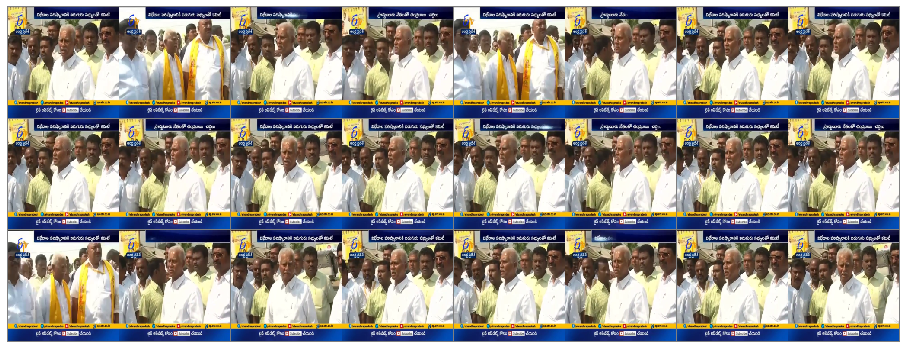

In [2]:
input=train_data[0][0]
plt.figure(figsize=(16, 16))
grid_border_size = 2
grid = utils.make_grid(input)

plt.imshow((grid.numpy().transpose((1, 2, 0))*0.5)+0.5)
plt.axis('off')
plt.ioff()
plt.show()

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [4]:
model=model.to(device)

In [5]:
criterion = nn.CrossEntropyLoss()  
loss_func = torch.nn.MSELoss()

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0002, betas=(0.5, 0.999))


In [7]:
f = open("result.txt",'a')

#Triaining
train_loss=[]
valid_accuracy=[]
num_epochs=50

model.train()
for epochs in range(0,num_epochs):
    first=True
    model.train()
    correct=0
    total_samples=0
    avg_tloss=0
    print("Training Epoch: ", epochs+1,"\n")
    for i_batch, (sample_batched,_,label) in enumerate(train_dataloader):
        
        batch_size=sample_batched.size(0)
        optimizer.zero_grad()
        sample_batched=sample_batched.to(device)
        output=model(sample_batched)
        loss=criterion(output,label.to(device))
        #loss=loss_func(output,label.float().to(device))
        loss.backward()
        predicted = torch.max(output, 1)
        prediction=predicted.indices.detach().cpu()
        correct +=num_correct(prediction,label)
        total_samples+=batch_size
        accuracy=correct/(total_samples)
        optimizer.step()
        true_label=label.detach().cpu()
        avg_tloss+=loss.item()
        if first:
            first=False
            conf_mat=confusion_matrix( true_label,prediction,labels=[0,1,2])
        else:
            conf_mat+=confusion_matrix(true_label,prediction,labels=[0,1,2])
        if i_batch%20==0:
            print(label)
            print("Batch: ",i_batch+1,"/",len(train_dataloader))
            print("Batch Recognition loss: ", loss.item())

    print(conf_mat)
    avg_tloss=avg_tloss/len(train_dataloader)
    avg_taccuracy=correct/total_samples
    print("Average_Loss: ",avg_tloss)
    print("Average_Accuracy: ",avg_taccuracy)
    
    torch.save(model,"model.h")
    print("Validation\n")
    
    model.eval()   
    correct=0
    total_samples=0
    avg_vloss=0
    first=True
    for i_batch, (sample_batched,_,label) in enumerate(valid_dataloader):
        batch_size=sample_batched.size(0)
        sample_batched=sample_batched.to(device)
        output=model(sample_batched)
        loss=criterion(output,label.to(device))
      #  loss=loss_func(output,label.float().to(device))
        avg_vloss+=loss.item()
        predicted = torch.max(output, 1)
        prediction=predicted.indices.detach().cpu()
        correct +=num_correct(prediction,label)
        total_samples+=batch_size
        
        true_label=label.detach().cpu()
        if first:
            first=False
            conf_mat=confusion_matrix( true_label,prediction,labels=[0,1,2])
        else:
            conf_mat+=confusion_matrix(true_label,prediction,labels=[0,1,2])
    print(conf_mat)
    avg_vloss=avg_vloss/len(valid_dataloader)
    print(avg_vloss)
    avg_vaccuracy=correct/(total_samples)
    print("Accuracy: ", avg_vaccuracy)
    
    data = " %d,%d,%d,%d \n" % (avg_tloss,avg_taccuracy,avg_vloss,avg_vaccuracy)
    f.write(data)

f.close()


Training Epoch:  1 

tensor([2, 1, 0, 0, 2, 0, 0, 2, 1, 2, 1, 0, 2, 0, 0, 1, 1, 1, 1, 2, 0, 1, 2, 2,
        0, 1, 1, 2, 1, 0, 0, 0], device='cpu')
Batch:  1 / 84
Batch Recognition loss:  1.0827438831329346
tensor([2, 0, 2, 0, 0, 2, 0, 1, 1, 0, 2, 2, 1, 1, 0, 2, 0, 2, 1, 2, 2, 1, 1, 1,
        0, 1, 2, 1, 0, 1, 1, 0], device='cpu')
Batch:  21 / 84
Batch Recognition loss:  0.9394345283508301
tensor([2, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 0, 1, 2, 2, 1, 2, 1, 0, 2, 1, 1, 1,
        2, 0, 1, 1, 1, 1, 1, 0], device='cpu')
Batch:  41 / 84
Batch Recognition loss:  0.9291065335273743
tensor([2, 0, 2, 1, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 0, 0, 2,
        1, 2, 2, 0, 0, 0, 1, 1], device='cpu')
Batch:  61 / 84
Batch Recognition loss:  1.0506010055541992
tensor([1, 0, 2, 2, 1, 2, 2, 1, 1, 0, 2, 1, 1, 1, 0, 1, 2, 2, 1, 1, 2, 2, 0, 2,
        2, 0, 1, 0, 0, 2, 0, 1], device='cpu')
Batch:  81 / 84
Batch Recognition loss:  1.0506526231765747
[[315 258 233]
 [192 495 236]
 [129 186 617]]

/opt/conda/envs/torch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Video_Feature. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/envs/torch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type DenseNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/envs/torch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/envs/torch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + 

Validation

[[ 43  72 184]
 [ 18 139 124]
 [  3  14 169]]
1.0575866649548213
Accuracy:  0.45822454308093996
Training Epoch:  2 

tensor([2, 0, 0, 1, 0, 2, 2, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 2,
        0, 1, 2, 2, 0, 2, 2, 2], device='cpu')
Batch:  1 / 84
Batch Recognition loss:  1.0613285303115845
tensor([2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 0, 0, 2, 2, 0, 1, 0, 2, 2, 2, 1, 2, 2, 0,
        0, 0, 1, 0, 1, 0, 2, 2], device='cpu')
Batch:  21 / 84
Batch Recognition loss:  0.9315026998519897
tensor([1, 1, 0, 2, 0, 2, 0, 1, 2, 1, 2, 1, 0, 1, 1, 2, 1, 0, 2, 2, 2, 1, 0, 2,
        1, 0, 1, 1, 2, 0, 1, 1], device='cpu')
Batch:  41 / 84
Batch Recognition loss:  0.9970501661300659
tensor([0, 1, 0, 2, 2, 2, 1, 2, 0, 2, 1, 1, 0, 0, 2, 2, 0, 1, 0, 2, 1, 2, 1, 2,
        2, 1, 0, 2, 0, 2, 2, 0], device='cpu')
Batch:  61 / 84
Batch Recognition loss:  0.9924799203872681
tensor([2, 1, 1, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 1, 2, 2, 2, 2, 0, 2, 0, 0, 0,
        0, 1, 1, 0, 2, 1, 1, 1], device='cpu

In [6]:
    model.eval()   
    correct=0
    total_samples=0
    avg_vloss=0
    first=True
    for i_batch, (sample_batched,_,label) in enumerate(valid_dataloader):
        batch_size=sample_batched.size(0)
        sample_batched=sample_batched.to(device)
        output=model(sample_batched)
        loss=criterion(output,label.to(device))
      #  loss=loss_func(output,label.float().to(device))
        avg_vloss+=loss.item()
        predicted = torch.max(output, 1)
        prediction=predicted.indices.detach().cpu()
        correct +=num_correct(prediction,label)
        total_samples+=batch_size
        
        true_label=label.detach().cpu()
        if first:
            first=False
            conf_mat=confusion_matrix( true_label,prediction,labels=[0,1,2])
        else:
            conf_mat+=confusion_matrix(true_label,prediction,labels=[0,1,2])
    print(conf_mat)
    avg_vloss=avg_vloss/len(valid_dataloader)
    print(avg_vloss)
    avg_vaccuracy=correct/(total_samples)
    print("Accuracy: ", avg_vaccuracy)
    
    data = " %d,%d,%d,%d \n" % (avg_tloss,avg_taccuracy,avg_vloss,avg_vaccuracy)


[[207  70  22]
 [198  71  12]
 [ 87  71  28]]
1.0961867719888687
Accuracy:  0.39947780678851175


NameError: name 'avg_tloss' is not defined